In [1]:
import time
import numpy as np

## Get trajectory

In [2]:
from clustering import Clustering,Trajectory


c = Clustering("laurier/laurier.sqlite","laurier/laurier-homography.txt")
c.get_trajectories(pixels = 1)
trajectories = [trajectory.pixel_trajectory for trajectory in c.trajectories]

## Get features
Distance between first and last point

Number of points in the trajectory

Trajectory_x   min, 25 , mean , 75 , max

Trajectory_y   min, 25 , mean , 75 , max

Velocity   min, 25 , mean , 75 , max

Rate of turn   min, 25 , mean , 75 , max

Difference between two consecutives Trajectory_x   min, 25 , mean , 75 , max

Difference between two consecutives Trajectory_y   min, 25 , mean , 75 , max

Difference between two consecutives Velocity   min, 25 , mean , 75 , max

Difference between two consecutives Rate of turn   min, 25 , mean , 75 , max

In [3]:
def compute_velocity(x1,x2,delta_t = 1):#pixel per frame
     #1 frame
    return np.sign(x2[0]-x1[0]) * euclidean(x1,x2) / delta_t

In [4]:
def compute_ROT(x1,x2):#rate of turn
    return np.arctan((x2[1]-x1[1])/(x2[0]-x1[0]))

In [5]:
def compute_velocities(trajectory):
    velocity = np.zeros(len(trajectory))
    for i in range(1,len(trajectory)):
        velocity[i] = compute_velocity(trajectory[i-1],trajectory[i])
    velocity[0] = velocity[1]
    return velocity

In [6]:
def compute_ROTS(trajectory):
    rot = np.zeros(len(trajectory))
    for i in range(1,len(trajectory)):
        rot[i] = compute_ROT(trajectory[i-1],trajectory[i])
    return rot

In [7]:
def get_difference(arr):
    results = []
    for e in arr:
        t = []
        for i in range(1,len(e)):
            #print(arr[i],arr[i-1])
            t.append(e[i]-e[i-1])
        results.append(t)
    return results

In [8]:
from scipy.spatial.distance import euclidean

trajectories_x = [[e[0] for e in trajectory] for trajectory in trajectories ]
trajectories_y = [[e[1] for e in trajectory] for trajectory in trajectories ]
velocities = [compute_velocities(trajectory) for trajectory in trajectories]
rots = [compute_ROTS(trajectory) for trajectory in trajectories]
nb_points = [trajectory.original_length for trajectory in c.trajectories]
distances = [ euclidean(trajectory[-1],trajectory[0]) for trajectory in trajectories ]

In [9]:
diff_x = get_difference(trajectories_x)
diff_y = get_difference(trajectories_y)
diff_v = get_difference(velocities)
diff_r = get_difference(rots)

In [10]:
s = [ trajectories_x,trajectories_y,velocities,rots,diff_x,diff_y,diff_v,diff_r ]

In [11]:
start = time.time()

import pandas as pd

data = []
for i in range(c.nb_trajectory):
    features = []
    features.append(nb_points[i])
    features.append(distances[i])
    
    for d in s:
        df = pd.DataFrame(d[i])
        df = df.describe().drop(['count','std']).values.flatten()
        for v in df:
            features.append(v)
    
    data.append(features)
    
end = time.time() - start

In [12]:
print(end)

55.6151108742


## Scaling the data

In [13]:
data = pd.DataFrame(data)

### MinMax scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler
mm_data = copy.copy(data)
scaler = MinMaxScaler()
mm_data[mm_data.columns] = scaler.fit_transform(mm_data[mm_data.columns]) 

### Standardization (gives better results)

In [14]:
from sklearn.preprocessing import StandardScaler
import copy

std_data = copy.copy(data)
scaler = StandardScaler()
std_data[std_data.columns] = scaler.fit_transform(std_data[std_data.columns]) 

### Correlation matrix

In [41]:
corr_matrix = std_data.corr()

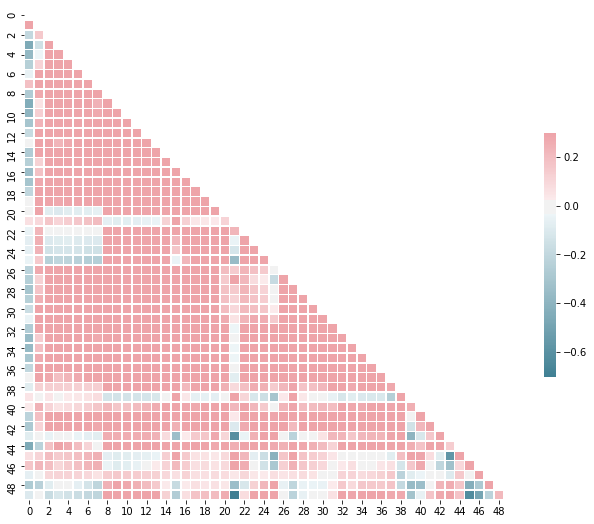

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,mask = mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Dimension reduction (PCA)
Can be use for clustering
Or clustering visualisation on 3D scatter plot with one color per cluster

In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)
pdf = pd.DataFrame(principalComponents)

### Clustering

In [26]:
std_data.to_csv("feat.csv")

In [32]:
std_data = pd.read_csv("feat.csv")

In [15]:
from sklearn.cluster import KMeans
nb_clusters = 6 #nb pair pour l'affichage

#### K-means on standardized data

In [16]:
clusters = KMeans(n_clusters=nb_clusters, random_state=0).fit_predict(std_data)

#### DB_SCAN on standardized data

In [96]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict(std_data)

In [127]:
nb_clusters = np.max(clusters) +1
print(nb_clusters)

count = 0
for j in clusters:
    if j == -1:
        count += 1
print(count)

3
0


### Hierarchical clustering

In [145]:
from sklearn.cluster import AgglomerativeClustering

clusters = AgglomerativeClustering(n_clusters=nb_clusters).fit_predict(std_data)

## Visualize clusters on frame

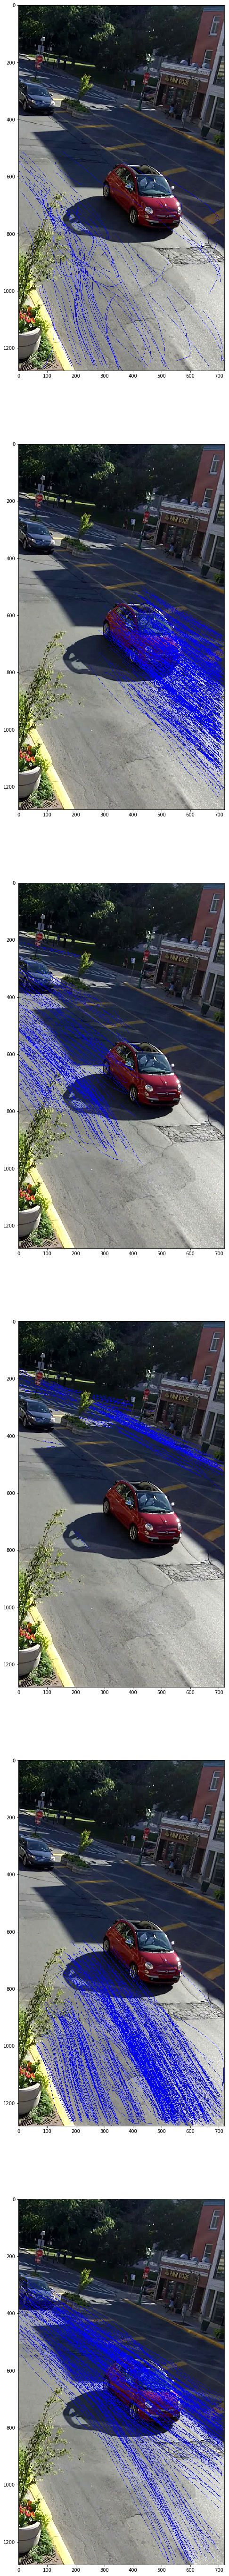

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import cv2

img = mpimg.imread("laurier/laurier.jpg")
fig = plt.figure(figsize=(10,100))

columns = 1
rows = nb_clusters

for i in range(nb_clusters):
    fig.add_subplot(rows,columns,i+1)
    img1 = copy.copy(img)
    for j,cl in enumerate(clusters):
        if cl == i:
            #img = mpimg.imread("laurier/laurier.jpg")
            
            pts = np.array(c.trajectories[j].pixel_trajectory , np.int32)
            pts = pts.reshape((-1,1,2))
            img1 = cv2.polylines(img1,[pts],False,(0,0,255)) 
    plt.imshow(img1)

plt.show()

### Visualize clustering in two dimensions with PCA

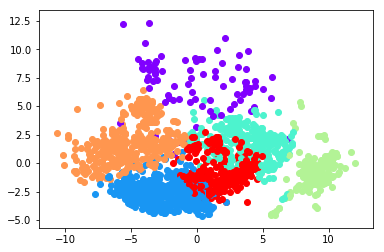

In [18]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)
ddf = pd.DataFrame(principalComponents)
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))


for i, row in ddf.iterrows():
    plt.scatter(row[0], row[1], color = colors[clusters[i]])
plt.show()

In [19]:
def display_clusters_aao(clusters,filename,pixel_trajectories,colors):
    nb_clusters = np.max(clusters)+1
    cap = cv2.VideoCapture(filename)
    ret, frame = cap.read()
    for i in range(nb_clusters):
        for j,c in enumerate(clusters):
            if c == i:
                pts = np.array(pixel_trajectories[j] , np.int32)
                pts = pts.reshape((-1,1,2))
                color = colors[clusters[j]] *255
                frame = cv2.polylines(frame,[pts],False,tuple(color[:-1]) )
    cv2.imshow('frame',frame)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
    #cap.release()
    #cv2.destroyAllWindows()



### Plot clustering projection 2D and on image

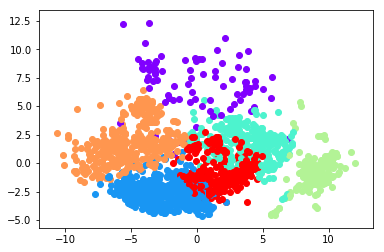

In [20]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)
ddf = pd.DataFrame(principalComponents)
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))
for i, row in ddf.iterrows():
    #if clusters[i] != -1:
    plt.scatter(row[0], row[1], color = colors[clusters[i]])
plt.show()



import matplotlib.cm as cm
import cv2
#colors = cm.rainbow(np.linspace(0, 1, nb_clusters))
filename = "laurier/laurier.avi"
display_clusters_aao(clusters,filename,trajectories,colors)

In [22]:
from utils import refactor_and_plot,display_clusters_oat
display_clusters_oat(clusters,"laurier/laurier.avi",[trajectory.pixel_trajectory for trajectory in c.trajectories])